In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import xgboost as xgb
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from src.features.neural_networks import ModelFC, PyTorchWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from src.features.functions import import_data,find_best_threshold, optimize_threshold_for_accuracy, predict_classification
from src.features.plots import plot_confusion_matrix,plot_roc_curve_and_accuracy

In [2]:
X_train, y_train, X_test, y_test = import_data()

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
logistic_regression_model = LogisticRegression()
random_forest_model = RandomForestClassifier(n_estimators=100)
xgboost_model =xgb.XGBClassifier()
torch_model = ModelFC(len(X_train.columns),len(y_train.columns),[8,8,8],0.5)
optimizer = optim.Adam(torch_model.parameters(),lr=0.001,weight_decay=0.001)
neural_network_model = PyTorchWrapper(torch_model,num_epochs=20)

# Crear el modelo ensamblado
model = VotingClassifier(estimators=[
    ('logistic_regression', logistic_regression_model),
    ('random_forest', random_forest_model),
    ('xgboost', xgboost_model),
    ('neural_network', neural_network_model),
], voting='soft')  # Utilizamos 'soft' voting para que se tengan en cuenta las probabilidades de clase en lugar de las predicciones de clase

model.fit(X_train, y_train)

c:\Users\User\.conda\envs\cuda\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\cuda\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\User\.conda\envs\cuda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

VotingClassifier(estimators=[('logistic_regression', LogisticRegression()),
                             ('random_forest', RandomForestClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=No...
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=1, bias=True)
  )
),
                                             num_epochs=20,
                                             optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)))],
                 voting='soft')

In [5]:
y_prob_val = model.predict_proba(X_val)[:, 1]

In [6]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
auc = roc_auc_score(y_val, y_prob_val)

In [7]:
best_threshold, threshold_accuracy = find_best_threshold(fpr, tpr, thresholds, y_val, y_prob_val)

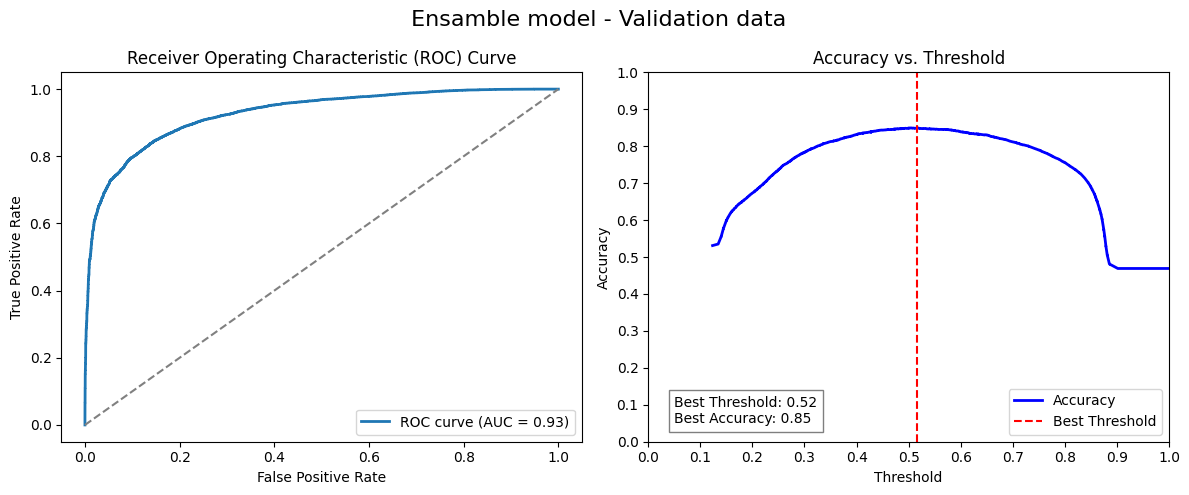

In [8]:
plot_roc_curve_and_accuracy(fpr, tpr, auc, thresholds, y_val, y_prob_val, " Ensamble model - Validation data")

In [9]:
optimal_threshold, optimal_accuracy = optimize_threshold_for_accuracy(y_val, y_prob_val)
print(f"Optimal Threshold: {optimal_threshold:.3}, Accuracy: {optimal_accuracy:.3}")

Optimal Threshold: 0.505, Accuracy: 0.849


In [10]:
y_pred = predict_classification(model,X_test,y_test,optimal_threshold,True)

Evaluation metrics:
Accuracy    :	0.854
F1 score    :	0.862
Precision   :	0.878
NVP         :	0.864
Sensitivity :	0.847
Specificity :	0.864


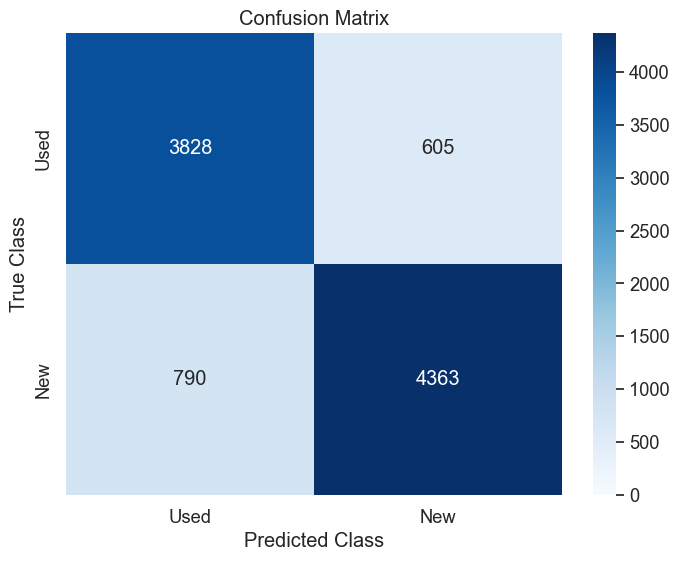

In [11]:
plot_confusion_matrix(y_test, y_pred,False,["Used","New"])